<a href="https://colab.research.google.com/github/LeninGF/CoursesNotes/blob/main/InteligenciaArtificalGenerativa/Problems/rnn-multiclass/EjercicioGeneracionTexto-IAG-2024B_LeninFalconiM2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RNN Multiclase

Coder: Lenin G. Falconí

Asignatura: Tópicos Especiales (Inteligencia Artificial)

Fecha: 2024-11-18

# Generación de Texto
Usando la información presentada, programar el código para la generación de texto basado en las frases de Sheldon para ejecutar en Kaggle.
Incluir la preparación de datos, definición del modelo, entrenamiento y generación de texto. Ajustar para mejorar resultados, comparar generación por caracteres vs. Generación por palabras. Probar para otros vocabularios.


In [24]:
# chars_window = 20  # Tamaño de la ventana deslizante
# step = 3           # Paso para mover la ventana
# n_epochs = 5      # Número de épocas (ajustable)
# batch_size = 128   # Tamaño del lote

seq_length = 100

## Carga del Texto
Se utiliza el libro de Don Quijote de la biblioteca Gutenberg. Se salta la parte de licencias

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding

# Load dataset
path_to_file = tf.keras.utils.get_file('don_quijote.txt', 'https://www.gutenberg.org/files/2000/2000-0.txt')


2226045/2226045 ━━━━━━━━━━━━━━━━━━━━ 2s 1us/step


In [2]:
# Read, then decode for py2 compat.
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print(f'Length of text: {len(text)} characters')

Length of text: 2168460 characters


In [10]:
start_of_text = text.find("El ingenioso hidalgo don Quijote de la Mancha")
text = text[start_of_text:]
len(text)

2167576

In [13]:
# Take a look at the first 250 characters in text
print(text[:250])

El ingenioso hidalgo don Quijote de la Mancha



por Miguel de Cervantes Saavedra





El ingenioso hidalgo don Quijote de la Mancha


  
Tasa

  
Testimonio de las erratas

  
El Rey

  
Al Duque de Béjar

  
Prólogo

  


In [14]:
# Create a vocabulary
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

103 unique characters


## Preprocesamiento
Donde vectorizamos el texto usando algunas librerías

In [16]:
example_texts = ['abcdefg', 'xyz']

chars = tf.strings.unicode_split(example_texts, input_encoding='UTF-8')
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

In [18]:
char_to_index = tf.keras.layers.StringLookup(vocabulary=list(vocab), mask_token=None)
index_to_char = tf.keras.layers.StringLookup(vocabulary=char_to_index.get_vocabulary(), invert=True, mask_token=None)
example_ids = char_to_index(chars)
example_ids

<tf.RaggedTensor [[57, 58, 59, 60, 61, 62, 63], [80, 81, 82]]>

In [20]:
def text_from_ids(ids):
  return tf.strings.reduce_join(index_to_char(ids), axis=-1)

text_from_ids(example_ids)

<tf.Tensor: shape=(2,), dtype=string, numpy=array([b'abcdefg', b'xyz'], dtype=object)>

## Generacion del Dataset

In [21]:
all_ids = char_to_index(tf.strings.unicode_split(text, 'UTF-8'))
all_ids

<tf.Tensor: shape=(2167576,), dtype=int64, numpy=array([34, 68,  3, ...,  1,  2,  1])>

In [22]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

In [23]:
for ids in ids_dataset.take(20):
    print(index_to_char(ids).numpy().decode('utf-8'))

E
l
 
i
n
g
e
n
i
o
s
o
 
h
i
d
a
l
g
o


Se genera secuencias de tamaño 101

In [25]:
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

for seq in sequences.take(1):
  print(index_to_char(seq))

tf.Tensor(
[b'E' b'l' b' ' b'i' b'n' b'g' b'e' b'n' b'i' b'o' b's' b'o' b' ' b'h'
 b'i' b'd' b'a' b'l' b'g' b'o' b' ' b'd' b'o' b'n' b' ' b'Q' b'u' b'i'
 b'j' b'o' b't' b'e' b' ' b'd' b'e' b' ' b'l' b'a' b' ' b'M' b'a' b'n'
 b'c' b'h' b'a' b'\r' b'\n' b'\r' b'\n' b'\r' b'\n' b'\r' b'\n' b'p' b'o'
 b'r' b' ' b'M' b'i' b'g' b'u' b'e' b'l' b' ' b'd' b'e' b' ' b'C' b'e'
 b'r' b'v' b'a' b'n' b't' b'e' b's' b' ' b'S' b'a' b'a' b'v' b'e' b'd'
 b'r' b'a' b'\r' b'\n' b'\r' b'\n' b'\r' b'\n' b'\r' b'\n' b'\r' b'\n'
 b'\r' b'\n' b'E' b'l' b' ' b'i'], shape=(101,), dtype=string)


Para visualizar de mejor manera

In [26]:
for seq in sequences.take(5):
  print(text_from_ids(seq).numpy())

b'El ingenioso hidalgo don Quijote de la Mancha\r\n\r\n\r\n\r\npor Miguel de Cervantes Saavedra\r\n\r\n\r\n\r\n\r\n\r\nEl i'
b'ngenioso hidalgo don Quijote de la Mancha\r\n\r\n\r\n  \r\nTasa\r\n\r\n  \r\nTestimonio de las erratas\r\n\r\n  \r\nEl Re'
b'y\r\n\r\n  \r\nAl Duque de B\xc3\xa9jar\r\n\r\n  \r\nPr\xc3\xb3logo\r\n\r\n  \r\nAl libro de don Quijote de la Mancha\r\n\r\n\r\n\r\nQue trat'
b'a de la condici\xc3\xb3n y ejercicio del famoso\r\nhidalgo don Quijote de la Mancha\r\n\r\nQue trata de la primera'
b' salida que de su tierra hizo\r\nel ingenioso don Quijote\r\n\r\nDonde se cuenta la graciosa manera que tuv'


Separando el dataset en un texto de entrada y su etiqueta

In [27]:
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

In [28]:
split_input_target(list("Tensorflow"))

(['T', 'e', 'n', 's', 'o', 'r', 'f', 'l', 'o'],
 ['e', 'n', 's', 'o', 'r', 'f', 'l', 'o', 'w'])

En este caso se maneja el mismo tamaño de secuencia solo que se desplaza a la siguiente letra forazando a la red a aprender que letra sigue a la anterior

In [29]:
dataset = sequences.map(split_input_target)

In [31]:
for input_example, target_example in dataset.take(1):
    print("Input :", text_from_ids(input_example).numpy())
    print("Target:", text_from_ids(target_example).numpy())

Input : b'El ingenioso hidalgo don Quijote de la Mancha\r\n\r\n\r\n\r\npor Miguel de Cervantes Saavedra\r\n\r\n\r\n\r\n\r\n\r\nEl '
Target: b'l ingenioso hidalgo don Quijote de la Mancha\r\n\r\n\r\n\r\npor Miguel de Cervantes Saavedra\r\n\r\n\r\n\r\n\r\n\r\nEl i'


Se generan batches para procesamiento

In [32]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

# Entrenamiento del Modelo

Se procede a realizar elentrenamiento del Modelo, definiendo algunas constantes estructurales

In [34]:
# Length of the vocabulary in StringLookup Layer
vocab_size = len(char_to_index.get_vocabulary())

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [35]:
def create_model(vocab_size, embedding_dim, rnn_units, input_length):
    inputs = tf.keras.Input(shape=(input_length,))
    x = tf.keras.layers.Embedding(vocab_size, embedding_dim)(inputs)
    x = tf.keras.layers.LSTM(rnn_units, return_sequences=True)(x)
    x = tf.keras.layers.Dropout(0.2)(x)  # Example dropout rate
    outputs = tf.keras.layers.Dense(vocab_size)(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

model = create_model(vocab_size=len(char_to_index.get_vocabulary()),
                     embedding_dim=256,
                     rnn_units=1024,
                     input_length=100)

In [36]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 100, 256)            │          26,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 100, 1024)           │       5,246,976 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 100, 1024)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 100, 104)            │         106,600 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,380,200 (20.52 MB)

 Trainable params: 5,380,200 (20.52 MB)

 Non-trainable params: 0 (0.00 B)

Probando el modelo sin entrenar

In [37]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 104) # (batch_size, sequence_length, vocab_size)


In [39]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()
sampled_indices

array([ 32,  26,   9,  12,  47,  77,  90,  99,  23,  44,   7,  41,  52,
        25,  32,  59,  81,  78,   7,  68,  45,  88,  22,  79,  73,  10,
        74,  98,  90,  11,  88,  87,  62,  19,  16,  21,  57,  51,   3,
        85,  13,  76,  58,   1, 101,  78,  40,  98,  28,  22,  14,  20,
        13,  49,  72, 102,  67,  64,   2,  82,  42,  51,  82,   1, 100,
        32,  27,  96,  29,  95,  49,  77,  19,  61, 102,  36,  67,  19,
        72,  41,  43,  16, 101,  47,   3,  84,  78,  81, 102,  73,  24,
        73,  58,  94,  50,  30,  99,  40,  27,  56])

In [40]:
print("Input:\n", text_from_ids(input_example_batch[0]).numpy())
print()
print("Next Char Predictions:\n", text_from_ids(sampled_indices).numpy())

Input:
 b', se tendi\xc3\xb3 en sus enjalmas y se dio a esperar a su\r\npuntual\xc3\xadsima Maritornes. Ya estaba Sancho bizma'

Next Char Predictions:
 b'C:(,Ru\xc3\x91\xc3\xb37O%LW9Ccyv%lP\xc3\x896wq)r\xc3\xb1\xc3\x91*\xc3\x89\xc3\x81f305aV \xc2\xbb-tb\n\xc3\xbavK\xc3\xb1?6.4-Tp\xc3\xbckh\rzMVz\n\xc3\xb9C;\xc3\xad@\xc3\xa9Tu3e\xc3\xbcGk3pLN0\xc3\xbaR \xc2\xabvy\xc3\xbcq8qb\xc3\xa1UA\xc3\xb3K;]'


## Entrenamiento

In [42]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])

Se configuran callbacks para  guardar checkpoints del modelo

In [45]:
import os

# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}.weights.h5")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [46]:
EPOCHS = 20

In [47]:
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/20
335/335 ━━━━━━━━━━━━━━━━━━━━ 32s 74ms/step - accuracy: 0.2714 - loss: 2.6740
Epoch 2/20
335/335 ━━━━━━━━━━━━━━━━━━━━ 27s 75ms/step - accuracy: 0.4536 - loss: 1.7795
Epoch 3/20
335/335 ━━━━━━━━━━━━━━━━━━━━ 42s 76ms/step - accuracy: 0.5251 - loss: 1.5347
Epoch 4/20
335/335 ━━━━━━━━━━━━━━━━━━━━ 41s 76ms/step - accuracy: 0.5583 - loss: 1.4152
Epoch 5/20
335/335 ━━━━━━━━━━━━━━━━━━━━ 27s 75ms/step - accuracy: 0.5779 - loss: 1.3427
Epoch 6/20
335/335 ━━━━━━━━━━━━━━━━━━━━ 27s 75ms/step - accuracy: 0.5917 - loss: 1.2935
Epoch 7/20
335/335 ━━━━━━━━━━━━━━━━━━━━ 42s 75ms/step - accuracy: 0.6016 - loss: 1.2561
Epoch 8/20
335/335 ━━━━━━━━━━━━━━━━━━━━ 27s 76ms/step - accuracy: 0.6098 - loss: 1.2261
Epoch 9/20
335/335 ━━━━━━━━━━━━━━━━━━━━ 27s 75ms/step - accuracy: 0.6177 - loss: 1.1984
Epoch 10/20
335/335 ━━━━━━━━━━━━━━━━━━━━ 41s 75ms/step - accuracy: 0.6246 - loss: 1.1751
Epoch 11/20
335/335 ━━━━━━━━━━━━━━━━━━━━ 41s 76ms/step - accuracy: 0.6316 - loss: 1.1506
Epoch 12/20
335/335 ━━━━━━━━━━

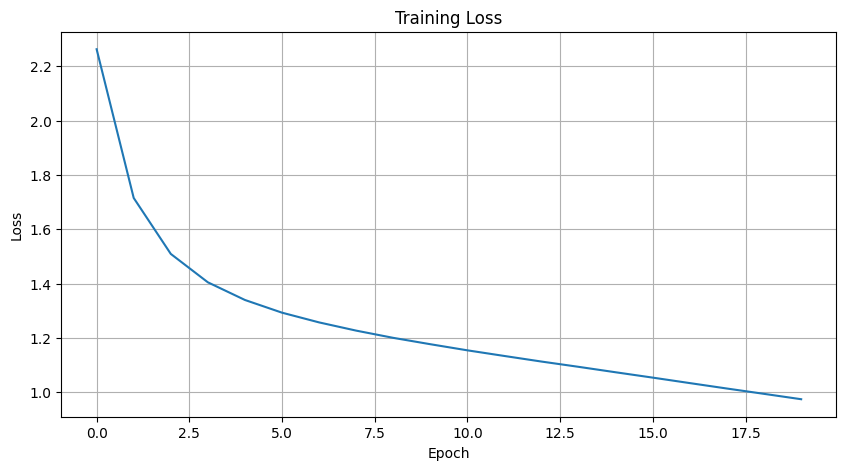

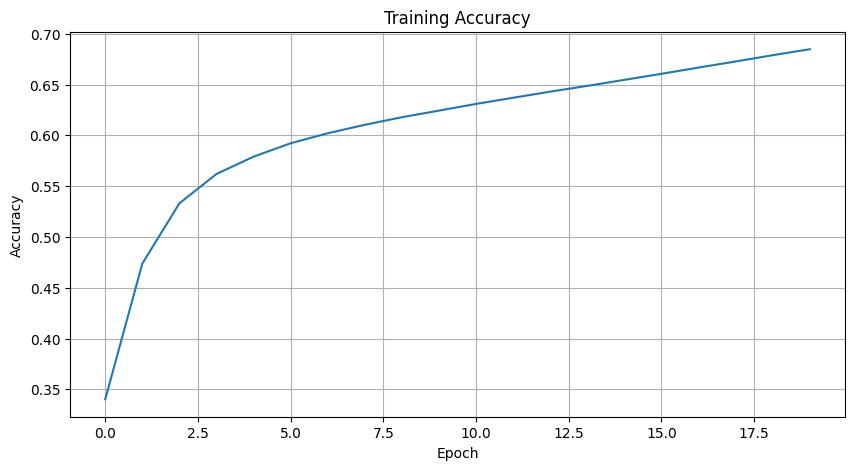

In [49]:
# prompt: code to plot the training loss and accuracy in separate plots and with grid

import matplotlib.pyplot as plt

# Assuming 'history' is the object returned by model.fit
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

Modelo

Generar Texto

In [88]:
import tensorflow as tf

def pad_to_seq_length(input_ids):
  """Pads the input sequence to length 100 with zeros.

  Args:
    input_ids: The input sequence as a 1D tensor.

  Returns:
    A padded sequence with shape (1, 100).
  """
  # Calculate the padding length
  padding_length = 100 - tf.shape(input_ids)[0]

  # If padding is needed, pad with zeros
  if padding_length > 0:
    padding = tf.zeros([padding_length], dtype=input_ids.dtype)
    padded_input_ids = tf.concat([input_ids, padding], axis=0)
  else:
    padded_input_ids = input_ids

  # Reshape to (1, 100) for the model
  return tf.reshape(padded_input_ids, [1, 100])


start_string = "el ingenioso hidalgo don quijote de la mancha"
input_ids = char_to_index(tf.strings.unicode_split(start_string, 'UTF-8'))

# Pad the input_ids
input_ids = pad_to_seq_length(input_ids)

# Now input_ids should have shape (1, 100)
y = model(input_ids)

In [89]:
y = tf.random.categorical(y[0], num_samples=1)
y = tf.squeeze(y, axis=-1).numpy()
y

array([74,  3, 59, 70, 57, 61, 70, 65, 71, 75, 71,  3, 61, 65, 60, 57, 68,
       63, 71,  3, 61, 71, 70,  3, 46, 77, 65, 61, 71, 76, 61,  3, 68, 61,
        3, 68, 57,  3, 42, 57, 68, 71, 64, 57, 63, 60, 14,  2,  3,  2, 57,
        2, 12, 74, 10, 74, 71, 75, 12, 12,  3,  9, 72, 12, 16, 63, 15, 63,
       16, 76, 63,  2, 61, 61, 12,  2, 12,  2, 61,  2, 61,  3,  2,  3,  3,
        2, 61,  2, 61,  2,  3, 13, 48, 13,  3, 54, 34, 61, 61,  9])

In [99]:
y.shape

(100,)

In [95]:
text_from_ids(y).numpy()

b'r cnaenioso eidalgo eon Quieote le la Malohagd.\r \ra\r,r)ros,, (p,0g/g0tg\ree,\r,\re\re \r  \re\re\r -S- YEee('

In [92]:
print(text_from_ids(y).numpy())

b'r cnaenioso eidalgo eon Quieote le la Malohagd.\r \ra\r,r)ros,, (p,0g/g0tg\ree,\r,\re\re \r  \re\re\r -S- YEee('


In [100]:
def generate_text(model, start_string, num_generate=10, temperature=1.0):
    input_ids = char_to_index(tf.strings.unicode_split(start_string, 'UTF-8'))
    input_ids = pad_to_seq_length(input_ids)  # Pad to sequence length

    text_generated = []

    for i in range(num_generate):
        # Get prediction for the next character
        predictions = model(input_ids)

        # Apply temperature for randomness
        predictions = predictions / temperature

        # Get the predicted character index
        predicted_id = tf.random.categorical(predictions[0, -1:, :], num_samples=1)[-1, 0].numpy()

        # Convert predicted index back to character
        predicted_char = index_to_char(predicted_id).numpy().decode('utf-8')

        # Append predicted character to generated text
        text_generated.append(predicted_char)

        # Slide the input window: Remove the first character and add the predicted one
        input_ids = tf.concat([input_ids[:, 1:], tf.reshape(predicted_id, [1, 1])], axis=1)

    return start_string + ''.join(text_generated)

In [117]:
print(generate_text(model, start_string="Sancho", temperature=0.5, num_generate=200))

Sancho, A LAPENT
LIALINY, ACHIANTE

Soneto

El caballero andante y se llamó a la mano el duque y la duquesa, y la cabeza a
la ventana y el labrador le avisase de su aldea, y así, por no dejar de la
p


A momentos se obtienen predicciones coherentes. Pero en otros casos se obtiene predicciones extravagantes y en inglés. Esto sugiere que se debe remover el texto en inglés del libro ya que lo afecta. Posiblemente. Esto no se nota al usar datasets como el de Shakespear